In [2]:
'''
author: Felix Hol
date: 2021 Feb 1
content: re-assign animal ID in DeepLabCut data to assign all individual tracks a unique ID
'''

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import os
from tqdm.notebook import tnrange, tqdm
import glob
import math
import deeplabcut

In [3]:
# dataFile = '/Users/felix/Documents/mosquitoes/mosquitoData/DLCtest/201204.h5'
dataFile = '/mnt/DATA/biteData/P3/201105_KPPTN/oldNet/test5000-15000_crf15DLC_resnet50_aedesNov16shuffle1_30000_bx.h5'
Dataframe = pd.read_hdf(dataFile)

In [4]:
Dataframe.head()

scorer      DLC_resnet50_aedesNov16shuffle1_30000                     \
individuals                                    m1                      
bodyparts                              proboscis1                      
coords                                          x       y likelihood   
0                                           566.0  2588.0   0.999512   
1                                           565.0  2588.0   0.999512   
2                                           564.5  2588.0   0.999512   
3                                           564.0  2588.0   0.999512   
4                                           556.0  2588.0   0.999023   

scorer                                                                   \
individuals                                                               
bodyparts   proboscis2                    proboscis3                      
coords               x       y likelihood          x       y likelihood   
0                590.5  2588.0   0.998047      620.5  2594.0   0.999512   
1                590.0  2588.0   0.996582      620.5  2594.0   0.999512   
2                590.0  2588.0   0.995117      620.0  2588.0   0.999512   
3                590.0  2588.0   0.995605      620.5  2594.0   0.999512   
4                580.5  2588.0   0.994629      620.5  2594.0   0.999512   

scorer              ...                                                        \
individuals         ...          m12                                            
bodyparts     head  ... leftHindleg1 leftHindleg2                leftHindleg3   
coords           x  ...   likelihood            x   y likelihood            x   
0            629.0  ...          NaN          NaN NaN        NaN          NaN   
1            629.0  ...          NaN          NaN NaN        NaN          NaN   
2            629.0  ...          NaN          NaN NaN        NaN          NaN   
3            629.0  ...          NaN          NaN NaN        NaN          NaN   
4            628.5  ...          NaN          NaN NaN        NaN          NaN   

scorer                                                  
individuals                                             
bodyparts                  leftHindleg4                 
coords        y likelihood            x   y likelihood  
0           NaN        NaN          NaN NaN        NaN  
1           NaN        NaN          NaN NaN        NaN  
2           NaN        NaN          NaN NaN        NaN  
3           NaN        NaN          NaN NaN        NaN  
4           NaN        NaN          NaN NaN        NaN  

[5 rows x 1260 columns]

In [5]:
scorer=Dataframe.columns.get_level_values(0)[0]

In [6]:
### Create a new dataframe with added column 'group' for each individual in which continuous stretches of a 
### trajectory are assigned a number g which can be used to extract the trajectory

dt = Dataframe.copy()

for ind in dt.columns.get_level_values(1).unique():
    dt[scorer, ind, 'group', 'g'] = (dt[scorer][ind]['abdomenC'].x.isnull().cumsum()  + 1) * ~dt[scorer][ind]['abdomenC'].x.isnull()


In [7]:
dt.tail()

scorer      DLC_resnet50_aedesNov16shuffle1_30000                     \
individuals                                    m1                      
bodyparts                              proboscis1                      
coords                                          x       y likelihood   
9995                                        556.0  2612.0   0.999512   
9996                                        556.0  2612.0   0.999512   
9997                                        556.0  2612.0   0.999023   
9998                                        556.0  2612.0   0.999512   
9999                                        556.5  2612.0   0.999023   

scorer                                                                   \
individuals                                                               
bodyparts   proboscis2                    proboscis3                      
coords               x       y likelihood          x       y likelihood   
9995             589.5  2610.0   0.992188      626.5  2604.0   1.000000   
9996             590.0  2610.0   0.993652      626.0  2604.0   0.999512   
9997             590.0  2610.0   0.993652      626.5  2604.0   0.999512   
9998             590.0  2612.0   0.993652      626.5  2604.0   1.000000   
9999             590.0  2610.0   0.991211      626.5  2604.0   1.000000   

scorer              ...                                                        \
individuals         ...    m3    m4    m5    m6    m7    m8    m9   m10   m11   
bodyparts     head  ... group group group group group group group group group   
coords           x  ...     g     g     g     g     g     g     g     g     g   
9995         636.0  ...  1015   682  1602  1461     0  3102     0     0     0   
9996         636.5  ...  1015   682  1602  1461     0  3102     0     0     0   
9997         636.5  ...  1015   682  1602  1461     0  3102     0     0     0   
9998         636.5  ...  1015   682  1602  1461     0  3102     0     0     0   
9999         636.5  ...  1015   682  1602  1461     0  3102     0     0     0   

scorer             
individuals   m12  
bodyparts   group  
coords          g  
9995            0  
9996            0  
9997            0  
9998            0  
9999            0  

[5 rows x 1272 columns]

In [8]:
D = Dataframe.copy()
bps = ['proboscis1', 'proboscis2', 'proboscis3', 'head', 'antennaR',
       'antennaL', 'thorax', 'abdomenC', 'abdomenR', 'abdomenL', 'bottom',
       'rightForeLeg1', 'rightForeLeg2', 'rightForeLeg3', 'rightForeLeg4',
       'leftForeLeg1', 'leftForeLeg2', 'leftForeLeg3', 'leftForeLeg4',
       'rightMidleg1', 'rightMidleg2', 'rightMidleg3', 'rightMidleg4',
       'leftMidleg1', 'leftMidleg2', 'leftMidleg3', 'leftMidleg4',
       'rightHindleg1', 'rightHindleg2', 'rightHindleg3', 'rightHindleg4',
       'leftHindleg1', 'leftHindleg2', 'leftHindleg3', 'leftHindleg4']
originalInd = D.columns.get_level_values(1).unique()   ###IDs of original dataframe
### list of columns without the grouper
newCs = [bps, ['x', 'y', 'likelihood']]

for ind in tqdm(originalInd):
    dInd = dt[scorer][ind].copy()
    for gID in dInd.group.g.unique():
        if gID != 0 :
            lastID = D.columns.get_level_values(1).unique()[-1]
            newID = str('m' + str(int(lastID[1:]) + 1))
            dInd_G = dInd.loc[dInd['group', 'g'] == gID].copy()
            dInd_G = dInd_G.drop('g', axis=1, level=1)
            dInd_G.columns = pd.MultiIndex.from_product([pd.Index([newID])] + newCs)
            dInd_G.columns = pd.MultiIndex.from_product([pd.Index([scorer])] + dInd_G.columns.levels)
            D = pd.concat([D, dInd_G], axis=1)
        
### remove original individuals
D = D.drop(originalInd, axis=1, level=1)
###I'm very sorry about the below lines, yet multiindex .from_product does not respect the order of columns
D.columns.set_levels(bps, level=2, inplace=True)
D = D.rename(columns={'likelihood': 'x', 'x': 'y', 'y': 'likelihood'})

###start individual number at 1:
numIndividuals = len(D.columns.get_level_values(1).unique())
indNames = []

for i in range(1,numIndividuals + 1):
    indNames.append('m' + str(i))
D.columns.set_levels(indNames, level=1, inplace=True)

In [9]:
D.head()

scorer      DLC_resnet50_aedesNov16shuffle1_30000                     \
individuals                                   m31                      
bodyparts                              proboscis1                      
coords                                          x       y likelihood   
0                                           566.0  2588.0   0.999512   
1                                           565.0  2588.0   0.999512   
2                                           564.5  2588.0   0.999512   
3                                           564.0  2588.0   0.999512   
4                                           556.0  2588.0   0.999023   

scorer                                                                   \
individuals                                                               
bodyparts   proboscis2                    proboscis3                      
coords               x       y likelihood          x       y likelihood   
0                590.5  2588.0   0.998047      620.5  2594.0   0.999512   
1                590.0  2588.0   0.996582      620.5  2594.0   0.999512   
2                590.0  2588.0   0.995117      620.0  2588.0   0.999512   
3                590.0  2588.0   0.995605      620.5  2594.0   0.999512   
4                580.5  2588.0   0.994629      620.5  2594.0   0.999512   

scorer              ...                                                        \
individuals         ...         m105                                            
bodyparts     head  ... leftHindleg1 leftHindleg2                leftHindleg3   
coords           x  ...   likelihood            x   y likelihood            x   
0            629.0  ...          NaN          NaN NaN        NaN          NaN   
1            629.0  ...          NaN          NaN NaN        NaN          NaN   
2            629.0  ...          NaN          NaN NaN        NaN          NaN   
3            629.0  ...          NaN          NaN NaN        NaN          NaN   
4            628.5  ...          NaN          NaN NaN        NaN          NaN   

scorer                                                  
individuals                                             
bodyparts                  leftHindleg4                 
coords        y likelihood            x   y likelihood  
0           NaN        NaN          NaN NaN        NaN  
1           NaN        NaN          NaN NaN        NaN  
2           NaN        NaN          NaN NaN        NaN  
3           NaN        NaN          NaN NaN        NaN  
4           NaN        NaN          NaN NaN        NaN  

[5 rows x 19425 columns]

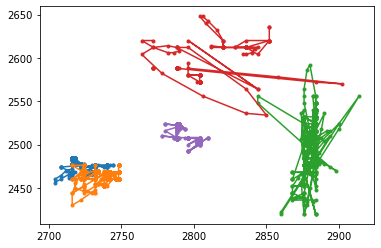

In [15]:
ind = 'm34'
plt.plot(D[scorer][ind]['abdomenC'].x, D[scorer][ind]['abdomenC'].y,'.-')
plt.plot(D[scorer][ind]['abdomenR'].x, D[scorer][ind]['abdomenR'].y,'.-')
plt.plot(D[scorer][ind]['rightForeLeg1'].x, D[scorer][ind]['rightForeLeg1'].y,'.-')
plt.plot(D[scorer][ind]['leftForeLeg1'].x, D[scorer][ind]['leftForeLeg1'].y,'.-')
plt.plot(D[scorer][ind]['head'].x, D[scorer][ind]['head'].y,'.-')

In [ ]:
f = '/home/felix/biteData/P3/210205_mp4/fileout.h5'
D.to_hdf(f, key="df_with_missing", mode="w")